In [44]:
import signals.utils as su
rolling_schema_output = su.get_futures_rolling_schema(ticker_head='CL',date_from=20100101, date_to=20171030)
liquid_contract_frame = rolling_schema_output['liquid_contract_frame']



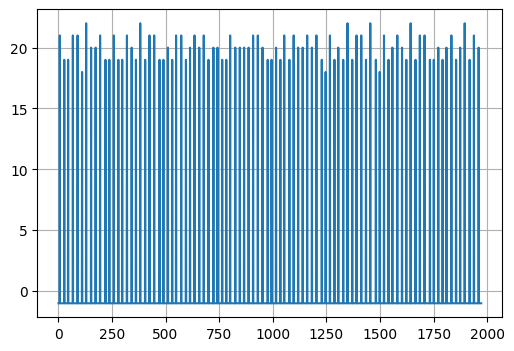

Min tr_dte_diff: -1.0
Max tr_dte_diff: 22.0


In [45]:
# the rolling structure seems optimal and orderly without multiple back and forths between the contracts.

liquid_contract_frame['tr_dte_diff'] = liquid_contract_frame['tr_dte'].diff()

%matplotlib inline
import matplotlib.pyplot as plt
#trade_data=big_data
plt.figure(figsize=(6,4))
plt.plot(range(len(liquid_contract_frame)),liquid_contract_frame['tr_dte_diff'])   # range(len(final_data))
plt.grid()
plt.show()

print('Min tr_dte_diff: ' + str(liquid_contract_frame['tr_dte_diff'].min()))
print('Max tr_dte_diff: ' + str(liquid_contract_frame['tr_dte_diff'].max()))

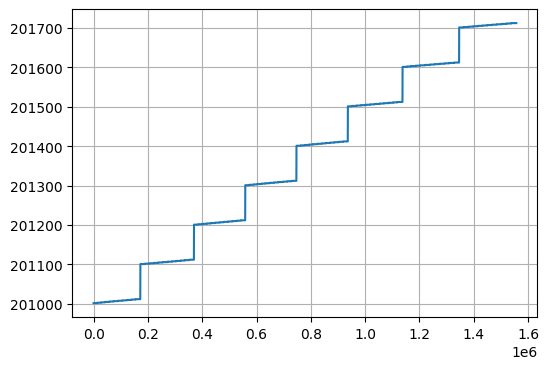

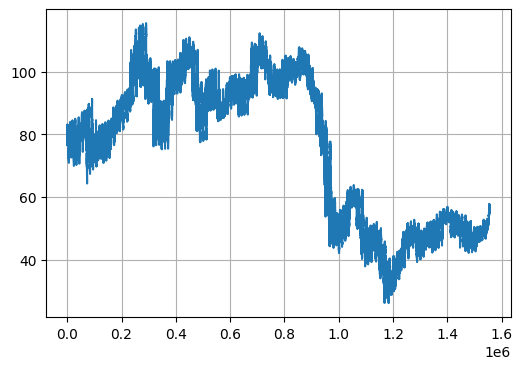

Num 5 minute obs: 1556978
Num 5 minute unique datetime obs: 572490


In [241]:
# The basic stitching of the intraday data seems to be without problems


import contract_utilities.contract_meta_info as cmi
import get_price.get_first_rate_intraday_data as id
import pandas as pd

ticker_list = liquid_contract_frame['ticker'].unique()
data_list = []

for ticker_i in ticker_list:

    contract_specs_output = cmi.get_contract_specs(ticker_i)

    data_out_5M = id.get_presaved_data(ticker=ticker_i, interval='5M')

    settle_dates_i = liquid_contract_frame.loc[liquid_contract_frame['ticker']==ticker_i,'settle_date']
    dates_after_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']>max(settle_dates_i),'settle_date']
    dates_before_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']<min(settle_dates_i),'settle_date']

    date_from_i = min(settle_dates_i)
    date_to_i = max(settle_dates_i)

    if len(dates_before_i)>0:
        date_from_i = dates_before_i.iloc[-3]

    if len(dates_after_i)>0:
        date_to_i = dates_after_i.iloc[2]

    data_out_5M['ticker'] = ticker_i
    data_out_5M['cont_indx'] = contract_specs_output['cont_indx']

    
    data_list.append(data_out_5M)

raw_data = pd.concat(data_list)

%matplotlib inline
import matplotlib.pyplot as plt
#trade_data=big_data
plt.figure(figsize=(6,4))
plt.plot(range(len(raw_data)),raw_data['cont_indx'])   # range(len(final_data))
plt.grid()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(len(raw_data)),raw_data['close'])   # range(len(final_data))
plt.grid()
plt.show()

print('Num 5 minute obs: ' + str(len(raw_data)))
print('Num 5 minute unique datetime obs: ' + str(len(raw_data.index.unique())))

In [2]:
import get_price.get_first_rate_intraday_data as id
data_out_5M = id.get_presaved_data(ticker='CLZ2015', interval='5M')
print(data_out_5M.tail())

                      open  close   high    low  volume
datetime                                               
2015-11-20 14:05:00  40.63  40.50  40.65  40.32     853
2015-11-20 14:10:00  40.49  40.56  40.57  40.41     698
2015-11-20 14:15:00  40.56  40.60  40.62  40.52     631
2015-11-20 14:20:00  40.58  40.23  40.59  40.16     818
2015-11-20 14:25:00  40.23  39.39  40.31  38.99     943


In [47]:
# Calculating of lags from individual contract data seems accurate


import contract_utilities.contract_meta_info as cmi
import get_price.get_first_rate_intraday_data as id
import pandas as pd

ticker_list = liquid_contract_frame['ticker'].unique()
data_list = []

for ticker_i in ticker_list:

    contract_specs_output = cmi.get_contract_specs(ticker_i)

    data_out_5M = id.get_presaved_data(ticker=ticker_i, interval='5M')

    settle_dates_i = liquid_contract_frame.loc[liquid_contract_frame['ticker']==ticker_i,'settle_date']
    dates_after_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']>max(settle_dates_i),'settle_date']
    dates_before_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']<min(settle_dates_i),'settle_date']

    date_from_i = min(settle_dates_i)
    date_to_i = max(settle_dates_i)

    if len(dates_before_i)>0:
        date_from_i = dates_before_i.iloc[-3]

    if len(dates_after_i)>0:
        date_to_i = dates_after_i.iloc[2]

    data_out_5M['ticker'] = ticker_i
    data_out_5M['cont_indx'] = contract_specs_output['cont_indx']

    for i in range(1,24):
            data_out_5M[['open_' + str(i),'high_' + str(i),'low_' + str(i),'close_' + str(i),'volume_' + str(i)]] = \
            data_out_5M[['open','high','low','close','volume']].shift(i)

    
    data_list.append(data_out_5M)

raw_data = pd.concat(data_list)
raw_data.insert(0, 'row_num', range(0,len(raw_data)))

# check for the integrity of individual contract lagged data
select_data = raw_data[raw_data['cont_indx']==201002]
print(select_data[['ticker','close','high','volume','close_1','high_1','close_7','high_7','volume_8']].iloc[:10])

# check for orderly shift from one contract to the next

roll_points = raw_data[raw_data['cont_indx'].diff()==1]
# Below 40 is selected randomly to inspect a contract roll somewhere in the middle
print(raw_data[['ticker','close','high','volume','close_1','high_1','close_7','high_7','volume_8']].iloc[roll_points['row_num'][40]-10:roll_points['row_num'][40]+10])

                      ticker  close   high  volume  close_1  high_1  close_7  \
datetime                                                                       
2009-10-15 00:40:00  CLG2010  77.34  77.34       3      NaN     NaN      NaN   
2009-10-15 01:05:00  CLG2010  77.40  77.40       3    77.34   77.34      NaN   
2009-10-15 02:20:00  CLG2010  77.32  77.32       1    77.40   77.40      NaN   
2009-10-15 02:35:00  CLG2010  77.18  77.18       1    77.32   77.32      NaN   
2009-10-15 03:20:00  CLG2010  77.04  77.04       2    77.18   77.18      NaN   
2009-10-15 03:40:00  CLG2010  77.15  77.15       2    77.04   77.04      NaN   
2009-10-15 04:05:00  CLG2010  77.13  77.19       2    77.15   77.15      NaN   
2009-10-15 04:10:00  CLG2010  77.09  77.09       2    77.13   77.19    77.34   
2009-10-15 04:15:00  CLG2010  77.20  77.20       2    77.09   77.09    77.40   
2009-10-15 04:25:00  CLG2010  77.22  77.22       1    77.20   77.20    77.32   

                     high_7  volume_8  

In [48]:
# data_out_5M = data_out_5M.loc[(data_out_5M.index>=date_from_i)&(data_out_5M.index<=date_to_i),:] line removes the unnecessary data 
# the behavior around the contract stitching points seem normal

import contract_utilities.contract_meta_info as cmi
import get_price.get_first_rate_intraday_data as id
import pandas as pd

ticker_list = liquid_contract_frame['ticker'].unique()
data_list = []

for ticker_i in ticker_list:

    contract_specs_output = cmi.get_contract_specs(ticker_i)

    data_out_5M = id.get_presaved_data(ticker=ticker_i, interval='5M')

    settle_dates_i = liquid_contract_frame.loc[liquid_contract_frame['ticker']==ticker_i,'settle_date']
    dates_after_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']>max(settle_dates_i),'settle_date']
    dates_before_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']<min(settle_dates_i),'settle_date']

    date_from_i = min(settle_dates_i)
    date_to_i = max(settle_dates_i)

    if len(dates_before_i)>0:
        date_from_i = dates_before_i.iloc[-3]

    if len(dates_after_i)>0:
        date_to_i = dates_after_i.iloc[2]

    data_out_5M = data_out_5M.loc[(data_out_5M.index>=date_from_i)&(data_out_5M.index<=date_to_i),:]
    data_out_5M['ticker'] = ticker_i
    data_out_5M['cont_indx'] = contract_specs_output['cont_indx']

    for i in range(1,24):
            data_out_5M[['open_' + str(i),'high_' + str(i),'low_' + str(i),'close_' + str(i),'volume_' + str(i)]] = \
            data_out_5M[['open','high','low','close','volume']].shift(i)

    
    data_list.append(data_out_5M)

raw_data = pd.concat(data_list)
raw_data.insert(0, 'row_num', range(0,len(raw_data)))

roll_points = raw_data[raw_data['cont_indx'].diff()==1]
# Below 40 is selected randomly to inspect a contract roll somewhere in the middle
print(raw_data[['ticker','close','high','volume','close_1','high_1','close_7','high_7','volume_8']].iloc[roll_points['row_num'][40]-10:roll_points['row_num'][40]+10])

                      ticker   close    high  volume  close_1  high_1  \
datetime                                                                
2013-08-13 23:15:00  CLU2013  106.58  106.58      13   106.57  106.60   
2013-08-13 23:20:00  CLU2013  106.56  106.59      33   106.58  106.58   
2013-08-13 23:25:00  CLU2013  106.54  106.56      32   106.56  106.59   
2013-08-13 23:30:00  CLU2013  106.54  106.58      35   106.54  106.56   
2013-08-13 23:35:00  CLU2013  106.53  106.54      19   106.54  106.58   
2013-08-13 23:40:00  CLU2013  106.45  106.52     233   106.53  106.54   
2013-08-13 23:45:00  CLU2013  106.40  106.49     302   106.45  106.52   
2013-08-13 23:50:00  CLU2013  106.43  106.44      12   106.40  106.49   
2013-08-13 23:55:00  CLU2013  106.35  106.43      58   106.43  106.44   
2013-08-14 00:00:00  CLU2013  106.31  106.36     117   106.35  106.43   
2013-08-07 00:00:00  CLV2013  104.78  104.78       1      NaN     NaN   
2013-08-07 00:20:00  CLV2013  104.86  104.86       

In [53]:
# data_2H = data_out_5M.resample('2H').last() is grabbing the last data points of two hour windows as expected
# it's also adding NaNs for weekends as expected


import contract_utilities.contract_meta_info as cmi
import get_price.get_first_rate_intraday_data as id
import pandas as pd

ticker_list = liquid_contract_frame['ticker'].unique()
data_list = []
data2H_list = []

for ticker_i in ticker_list:

    contract_specs_output = cmi.get_contract_specs(ticker_i)

    data_out_5M = id.get_presaved_data(ticker=ticker_i, interval='5M')

    settle_dates_i = liquid_contract_frame.loc[liquid_contract_frame['ticker']==ticker_i,'settle_date']
    dates_after_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']>max(settle_dates_i),'settle_date']
    dates_before_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']<min(settle_dates_i),'settle_date']

    date_from_i = min(settle_dates_i)
    date_to_i = max(settle_dates_i)

    if len(dates_before_i)>0:
        date_from_i = dates_before_i.iloc[-3]

    if len(dates_after_i)>0:
        date_to_i = dates_after_i.iloc[2]

    data_out_5M = data_out_5M.loc[(data_out_5M.index>=date_from_i)&(data_out_5M.index<=date_to_i),:]
    data_out_5M['ticker'] = ticker_i
    data_out_5M['cont_indx'] = contract_specs_output['cont_indx']

    for i in range(1,24):
            data_out_5M[['open_' + str(i),'high_' + str(i),'low_' + str(i),'close_' + str(i),'volume_' + str(i)]] = \
            data_out_5M[['open','high','low','close','volume']].shift(i)
    
    data_2H = data_out_5M.resample('2H').last()

    
    data_list.append(data_out_5M)
    data2H_list.append(data_2H)

raw_data = pd.concat(data_list)
raw_data.insert(0, 'row_num', range(0,len(raw_data)))

raw2H_data = pd.concat(data2H_list)
raw2H_data.insert(0, 'row_num', range(0,len(raw2H_data)))


# Below 40 is selected randomly to inspect a contract roll somewhere in the middle
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', 1000):
    roll_points = raw_data[raw_data['cont_indx'].diff()==1]
    print(raw_data[['ticker','close','high','volume','close_1','high_1','close_7','high_7','volume_8']].iloc[roll_points['row_num'][40]-50:roll_points['row_num'][40]+50])
    roll_points = raw2H_data[raw2H_data['cont_indx'].diff()==1]
    print(raw2H_data[['ticker','close','high','volume','close_1','high_1','close_7','high_7','volume_8']].iloc[roll_points['row_num'][40]-50:roll_points['row_num'][40]+50])

                      ticker   close    high  volume  close_1  high_1  close_7  high_7  volume_8
datetime                                                                                        
2013-08-13 19:55:00  CLU2013  106.50  106.52      16   106.50  106.51   106.52  106.53      58.0
2013-08-13 20:00:00  CLU2013  106.49  106.51      44   106.50  106.52   106.52  106.56      18.0
2013-08-13 20:05:00  CLU2013  106.51  106.51      14   106.49  106.51   106.52  106.52      17.0
2013-08-13 20:10:00  CLU2013  106.50  106.51      19   106.51  106.51   106.49  106.51      11.0
2013-08-13 20:15:00  CLU2013  106.48  106.50      21   106.50  106.51   106.51  106.52       8.0
2013-08-13 20:20:00  CLU2013  106.50  106.50      11   106.48  106.50   106.50  106.53       9.0
2013-08-13 20:25:00  CLU2013  106.49  106.52      12   106.50  106.50   106.50  106.51      14.0
2013-08-13 20:30:00  CLU2013  106.49  106.50      18   106.49  106.52   106.50  106.52       6.0
2013-08-13 20:35:00  CLU2013  

In [57]:
# data_2H.dropna(subset='close', inplace=True) removes the weekend NaNs
# that are coming from resampling.
#  Calculation of 'percent_diff', 'std' and 'percent_diff1' seems accurate 
# and transition during the contract roll seems as expected

import contract_utilities.contract_meta_info as cmi
import get_price.get_first_rate_intraday_data as id
import pandas as pd

ticker_list = liquid_contract_frame['ticker'].unique()
data_list = []

for ticker_i in ticker_list:

    contract_specs_output = cmi.get_contract_specs(ticker_i)

    data_out_5M = id.get_presaved_data(ticker=ticker_i, interval='5M')

    settle_dates_i = liquid_contract_frame.loc[liquid_contract_frame['ticker']==ticker_i,'settle_date']
    dates_after_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']>max(settle_dates_i),'settle_date']
    dates_before_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']<min(settle_dates_i),'settle_date']

    date_from_i = min(settle_dates_i)
    date_to_i = max(settle_dates_i)

    if len(dates_before_i)>0:
        date_from_i = dates_before_i.iloc[-3]

    if len(dates_after_i)>0:
        date_to_i = dates_after_i.iloc[2]

    data_out_5M = data_out_5M.loc[(data_out_5M.index>=date_from_i)&(data_out_5M.index<=date_to_i),:]
    data_out_5M['ticker'] = ticker_i
    data_out_5M['cont_indx'] = contract_specs_output['cont_indx']

    for i in range(1,24):
        data_out_5M[['open_' + str(i),'high_' + str(i),'low_' + str(i),'close_' + str(i),'volume_' + str(i)]] = \
        data_out_5M[['open','high','low','close','volume']].shift(i)

    data_2H = data_out_5M.resample('2H').last()
    data_2H.dropna(subset='close', inplace=True)
    data_2H['percent_diff'] = data_2H['close'].diff()/data_2H['close'].shift(1)
    data_2H['std'] = data_2H['percent_diff'].rolling(10).std()
    data_2H['percent_diff1'] = data_2H['percent_diff'].shift(-1)

    data_list.append(data_2H)

raw_data = pd.concat(data_list)
raw_data.insert(0, 'row_num', range(0,len(raw_data)))


# Below 40 is selected randomly to inspect a contract roll somewhere in the middle
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    roll_points = raw_data[raw_data['cont_indx'].diff()==1]
    print(raw_data[['ticker','close','close_1','std','percent_diff','percent_diff1']].iloc[roll_points['row_num'][40]-50:roll_points['row_num'][40]+50])

                      ticker   close  close_1       std  percent_diff  percent_diff1
datetime                                                                            
2013-08-07 22:00:00  CLU2013  104.82   104.83  0.002747      0.001624      -0.003053
2013-08-08 00:00:00  CLU2013  104.50   104.57  0.002734     -0.003053      -0.002201
2013-08-08 02:00:00  CLU2013  104.27   104.21  0.002767     -0.002201      -0.000671
2013-08-08 04:00:00  CLU2013  104.20   104.18  0.002764     -0.000671       0.000576
2013-08-08 06:00:00  CLU2013  104.26   104.18  0.002722      0.000576      -0.007481
2013-08-08 08:00:00  CLU2013  103.48   103.44  0.003147     -0.007481      -0.006281
2013-08-08 10:00:00  CLU2013  102.83   102.80  0.003566     -0.006281      -0.000972
2013-08-08 12:00:00  CLU2013  102.73   102.63  0.003511     -0.000972       0.010221
2013-08-08 14:00:00  CLU2013  103.78   103.69  0.005087      0.010221       0.000964
2013-08-08 16:00:00  CLU2013  103.88   103.86  0.004877      0.00

In [58]:
# data_2H = data_2H.loc[(data_2H.index >= date_from_i) & (data_2H.index <= date_to_i), :]
# removes the unecessary data after the calculation of indicators
# this line in necessary to be as close to the contract rolling schema as provided by get_futures_rolling_schema()

import contract_utilities.contract_meta_info as cmi
import get_price.get_first_rate_intraday_data as id
import pandas as pd

ticker_list = liquid_contract_frame['ticker'].unique()
data_list = []

for ticker_i in ticker_list:

    contract_specs_output = cmi.get_contract_specs(ticker_i)

    data_out_5M = id.get_presaved_data(ticker=ticker_i, interval='5M')

    settle_dates_i = liquid_contract_frame.loc[liquid_contract_frame['ticker']==ticker_i,'settle_date']
    dates_after_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']>max(settle_dates_i),'settle_date']
    dates_before_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']<min(settle_dates_i),'settle_date']

    date_from_i = min(settle_dates_i)
    date_to_i = max(settle_dates_i)

    if len(dates_before_i)>0:
        date_from_i = dates_before_i.iloc[-3]

    if len(dates_after_i)>0:
        date_to_i = dates_after_i.iloc[2]

    data_out_5M = data_out_5M.loc[(data_out_5M.index>=date_from_i)&(data_out_5M.index<=date_to_i),:]
    data_out_5M['ticker'] = ticker_i
    data_out_5M['cont_indx'] = contract_specs_output['cont_indx']

    for i in range(1,24):
        data_out_5M[['open_' + str(i),'high_' + str(i),'low_' + str(i),'close_' + str(i),'volume_' + str(i)]] = \
        data_out_5M[['open','high','low','close','volume']].shift(i)

    data_2H = data_out_5M.resample('2H').last()
    data_2H.dropna(subset='close', inplace=True)
    data_2H['percent_diff'] = data_2H['close'].diff()/data_2H['close'].shift(1)
    data_2H['std'] = data_2H['percent_diff'].rolling(10).std()
    data_2H['percent_diff1'] = data_2H['percent_diff'].shift(-1)

    if len(dates_before_i)>0:
        date_from_i = dates_before_i.iloc[-1]

    if len(dates_after_i)>0:
        date_to_i = dates_after_i.iloc[0]

    data_2H = data_2H.loc[(data_2H.index >= date_from_i) & (data_2H.index <= date_to_i), :]

    data_list.append(data_2H)

raw_data = pd.concat(data_list)
raw_data.insert(0, 'row_num', range(0,len(raw_data)))


# Below 40 is selected randomly to inspect a contract roll somewhere in the middle
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    roll_points = raw_data[raw_data['cont_indx'].diff()==1]
    print(raw_data[['ticker','close','close_1','std','percent_diff','percent_diff1']].iloc[roll_points['row_num'][40]-50:roll_points['row_num'][40]+50])

                      ticker   close  close_1       std  percent_diff  percent_diff1
datetime                                                                            
2013-08-05 22:00:00  CLU2013  106.38   106.38  0.004539      0.001035       0.000188
2013-08-06 00:00:00  CLU2013  106.40   106.38  0.003246      0.000188      -0.002820
2013-08-06 02:00:00  CLU2013  106.10   106.05  0.003021     -0.002820       0.007917
2013-08-06 04:00:00  CLU2013  106.94   106.90  0.003894      0.007917       0.000374
2013-08-06 06:00:00  CLU2013  106.98   106.99  0.003052      0.000374      -0.013741
2013-08-06 08:00:00  CLU2013  105.51   105.74  0.005355     -0.013741      -0.000474
2013-08-06 10:00:00  CLU2013  105.46   105.33  0.005315     -0.000474      -0.004077
2013-08-06 12:00:00  CLU2013  105.03   105.01  0.005395     -0.004077       0.003618
2013-08-06 14:00:00  CLU2013  105.41   105.39  0.005615      0.003618       0.002751
2013-08-06 16:00:00  CLU2013  105.70   105.71  0.005730      0.00

In [61]:
# raw_data.sort_values(['datetime_', 'cont_indx'], ascending=[True, False], inplace=True)
# sorts the data as expected during the contract roll dates


import contract_utilities.contract_meta_info as cmi
import get_price.get_first_rate_intraday_data as id
import pandas as pd



ticker_list = liquid_contract_frame['ticker'].unique()
data_list = []

for ticker_i in ticker_list:

    contract_specs_output = cmi.get_contract_specs(ticker_i)

    data_out_5M = id.get_presaved_data(ticker=ticker_i, interval='5M')

    settle_dates_i = liquid_contract_frame.loc[liquid_contract_frame['ticker']==ticker_i,'settle_date']
    dates_after_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']>max(settle_dates_i),'settle_date']
    dates_before_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']<min(settle_dates_i),'settle_date']

    date_from_i = min(settle_dates_i)
    date_to_i = max(settle_dates_i)

    if len(dates_before_i)>0:
        date_from_i = dates_before_i.iloc[-3]

    if len(dates_after_i)>0:
        date_to_i = dates_after_i.iloc[2]

    data_out_5M = data_out_5M.loc[(data_out_5M.index>=date_from_i)&(data_out_5M.index<=date_to_i),:]
    data_out_5M['ticker'] = ticker_i
    data_out_5M['cont_indx'] = contract_specs_output['cont_indx']

    for i in range(1,24):
        data_out_5M[['open_' + str(i),'high_' + str(i),'low_' + str(i),'close_' + str(i),'volume_' + str(i)]] = \
        data_out_5M[['open','high','low','close','volume']].shift(i)

    data_2H = data_out_5M.resample('2H').last()
    data_2H.dropna(subset='close', inplace=True)
    data_2H['percent_diff'] = data_2H['close'].diff()/data_2H['close'].shift(1)
    data_2H['std'] = data_2H['percent_diff'].rolling(10).std()
    data_2H['percent_diff1'] = data_2H['percent_diff'].shift(-1)

    if len(dates_before_i)>0:
        date_from_i = dates_before_i.iloc[-1]

    if len(dates_after_i)>0:
        date_to_i = dates_after_i.iloc[0]

    data_2H = data_2H.loc[(data_2H.index >= date_from_i) & (data_2H.index <= date_to_i), :]

    data_list.append(data_2H)

raw_data = pd.concat(data_list)
raw_data.insert(0, 'row_num', range(0,len(raw_data)))
raw_data['settle_date'] = pd.to_datetime(raw_data.index.date)
raw_data['datetime_'] = pd.to_datetime(raw_data.index)
raw_data.sort_values(['datetime_', 'cont_indx'], ascending=[True, False], inplace=True)


# Below 201310 is selected because of its relevancy within the previously looked data
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
     contract_data = raw_data[raw_data['cont_indx']==201310]
     print(raw_data[['ticker','close','close_1','std','percent_diff','percent_diff1']].iloc[contract_data['row_num'][0]-50:contract_data['row_num'][0]+50])

                      ticker   close  close_1       std  percent_diff  percent_diff1
datetime                                                                            
2013-08-05 22:00:00  CLU2013  106.38   106.38  0.004539      0.001035       0.000188
2013-08-06 00:00:00  CLU2013  106.40   106.38  0.003246      0.000188      -0.002820
2013-08-06 02:00:00  CLU2013  106.10   106.05  0.003021     -0.002820       0.007917
2013-08-06 04:00:00  CLU2013  106.94   106.90  0.003894      0.007917       0.000374
2013-08-06 06:00:00  CLU2013  106.98   106.99  0.003052      0.000374      -0.013741
2013-08-06 08:00:00  CLU2013  105.51   105.74  0.005355     -0.013741      -0.000474
2013-08-06 10:00:00  CLU2013  105.46   105.33  0.005315     -0.000474      -0.004077
2013-08-06 12:00:00  CLU2013  105.03   105.01  0.005395     -0.004077       0.003618
2013-08-06 14:00:00  CLU2013  105.41   105.39  0.005615      0.003618       0.002751
2013-08-06 16:00:00  CLU2013  105.70   105.71  0.005730      0.00

In [63]:
# raw_data.drop_duplicates(subset='datetime_', keep='first', inplace=True)
# removes the duplicate rows as expected and provides a smooth contract roll

ticker_list = liquid_contract_frame['ticker'].unique()
data_list = []

for ticker_i in ticker_list:

    contract_specs_output = cmi.get_contract_specs(ticker_i)

    data_out_5M = id.get_presaved_data(ticker=ticker_i, interval='5M')

    settle_dates_i = liquid_contract_frame.loc[liquid_contract_frame['ticker']==ticker_i,'settle_date']
    dates_after_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']>max(settle_dates_i),'settle_date']
    dates_before_i = liquid_contract_frame.loc[liquid_contract_frame['settle_date']<min(settle_dates_i),'settle_date']

    date_from_i = min(settle_dates_i)
    date_to_i = max(settle_dates_i)

    if len(dates_before_i)>0:
        date_from_i = dates_before_i.iloc[-3]

    if len(dates_after_i)>0:
        date_to_i = dates_after_i.iloc[2]

    data_out_5M = data_out_5M.loc[(data_out_5M.index>=date_from_i)&(data_out_5M.index<=date_to_i),:]
    data_out_5M['ticker'] = ticker_i
    data_out_5M['cont_indx'] = contract_specs_output['cont_indx']

    for i in range(1,24):
        data_out_5M[['open_' + str(i),'high_' + str(i),'low_' + str(i),'close_' + str(i),'volume_' + str(i)]] = \
        data_out_5M[['open','high','low','close','volume']].shift(i)

    data_2H = data_out_5M.resample('2H').last()
    data_2H.dropna(subset='close', inplace=True)
    data_2H['percent_diff'] = data_2H['close'].diff()/data_2H['close'].shift(1)
    data_2H['std'] = data_2H['percent_diff'].rolling(10).std()
    data_2H['percent_diff1'] = data_2H['percent_diff'].shift(-1)

    if len(dates_before_i)>0:
        date_from_i = dates_before_i.iloc[-1]

    if len(dates_after_i)>0:
        date_to_i = dates_after_i.iloc[0]

    data_2H = data_2H.loc[(data_2H.index >= date_from_i) & (data_2H.index <= date_to_i), :]

    data_list.append(data_2H)

raw_data = pd.concat(data_list)
raw_data['settle_date'] = pd.to_datetime(raw_data.index.date)
raw_data['datetime_'] = pd.to_datetime(raw_data.index)
raw_data.sort_values(['datetime_', 'cont_indx'], ascending=[True, False], inplace=True)
raw_data.drop_duplicates(subset='datetime_', keep='first', inplace=True)
raw_data.insert(0, 'row_num', range(0,len(raw_data)))

# Below 201310 is selected because of its relevancy within the previously looked data
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
     contract_data = raw_data[raw_data['cont_indx']==201310]
     print(raw_data[['ticker','close','close_1','std','percent_diff','percent_diff1']].iloc[contract_data['row_num'][0]-50:contract_data['row_num'][0]+50])

                      ticker   close  close_1       std  percent_diff  percent_diff1
datetime                                                                            
2013-08-04 20:00:00  CLU2013  106.71   106.74  0.002857      0.000563       0.004217
2013-08-04 22:00:00  CLU2013  107.16   107.19  0.003337      0.004217       0.001866
2013-08-05 00:00:00  CLU2013  107.36   107.35  0.003387      0.001866       0.001118
2013-08-05 02:00:00  CLU2013  107.48   107.39  0.003419      0.001118      -0.010048
2013-08-05 04:00:00  CLU2013  106.40   106.40  0.003856     -0.010048      -0.004511
2013-08-05 06:00:00  CLU2013  105.92   106.08  0.004040     -0.004511       0.001227
2013-08-05 08:00:00  CLU2013  106.05   105.96  0.004069      0.001227       0.007732
2013-08-05 10:00:00  CLU2013  106.87   106.85  0.004847      0.007732      -0.000842
2013-08-05 12:00:00  CLU2013  106.78   106.83  0.004839     -0.000842      -0.003090
2013-08-05 14:00:00  CLU2013  106.45   106.47  0.004892     -0.00

In [68]:
# prepare_2H_data() seems to be calculating the labels correctly 
# and the contract roll looks smooth

import strategy_development.cnn.cnn2.prepare_data as prep
final_data = prep.prepare_2H_data()
final_data.insert(0, 'row_num', range(0,len(final_data)))

# Below 201310 is selected because of its relevancy within the previously looked data
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
     contract_data = final_data[final_data['cont_indx']==201310]
     print(final_data[['ticker','close','close_1','std','percent_diff','percent_diff1','label']].iloc[contract_data['row_num'][0]-50:contract_data['row_num'][0]+50])

                      ticker   close  close_1       std  percent_diff  percent_diff1  label
datetime                                                                                   
2013-08-04 20:00:00  CLU2013  106.71   106.74  0.002857      0.000563       0.004217      2
2013-08-04 22:00:00  CLU2013  107.16   107.19  0.003337      0.004217       0.001866      2
2013-08-05 00:00:00  CLU2013  107.36   107.35  0.003387      0.001866       0.001118      1
2013-08-05 02:00:00  CLU2013  107.48   107.39  0.003419      0.001118      -0.010048      0
2013-08-05 04:00:00  CLU2013  106.40   106.40  0.003856     -0.010048      -0.004511      0
2013-08-05 06:00:00  CLU2013  105.92   106.08  0.004040     -0.004511       0.001227      1
2013-08-05 08:00:00  CLU2013  106.05   105.96  0.004069      0.001227       0.007732      2
2013-08-05 10:00:00  CLU2013  106.87   106.85  0.004847      0.007732      -0.000842      1
2013-08-05 12:00:00  CLU2013  106.78   106.83  0.004839     -0.000842      -0.00

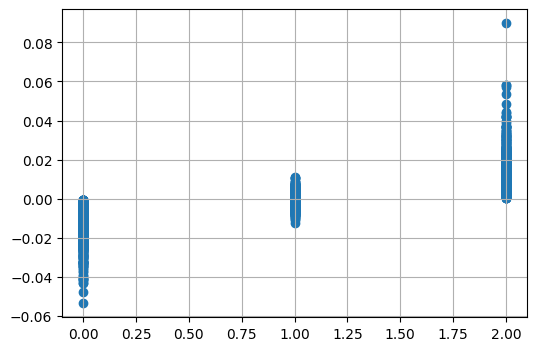

Num 0 labels: 5688
Num 1 labels: 12756
Num 2 labels: 5658


In [243]:
# scatter plot analysis of the labels also implies and accurate calculation

%matplotlib inline
import matplotlib.pyplot as plt
#trade_data=big_data
plt.figure(figsize=(6,4))
plt.scatter(final_data['label'],final_data['percent_diff1'])   # range(len(final_data))
plt.grid()
plt.show()

print("Num 0 labels: " + str(sum(final_data['label']==0)))
print("Num 1 labels: " + str(sum(final_data['label']==1)))
print("Num 2 labels: " + str(sum(final_data['label']==2)))

In [162]:
# the data seems to be in expected quantity for a 2H data with no missing observations 

data_time_span = (final_data['datetime_'].iloc[-1]-final_data['datetime_'].iloc[0]).days
expected_num_obs_per_week = 12*7-24
expected_num_obs = (data_time_span/7)*expected_num_obs_per_week
print('Expected num obs: ' + str(expected_num_obs))
print('Num obs: ' + str(len(final_data)))
print('Holidays etc: ' + str(100*len(final_data)/expected_num_obs))

print('Number of null labels: ' + str(sum(final_data['label'].isnull())))
print('Number of null close: ' + str(sum(final_data['close'].isnull())))

print('Number of null high_23: ' + str(sum(final_data['high_23'].isnull())))
print('Number of null volume_23: ' + str(sum(final_data['volume_23'].isnull())))
print('Number of null open_19: ' + str(sum(final_data['open_19'].isnull())))

Expected num obs: 24471.42857142857
Num obs: 24102
Holidays etc: 98.49036777583188
Number of null labels: 0
Number of null close: 0
Number of null high_23: 0
Number of null volume_23: 0
Number of null open_19: 0


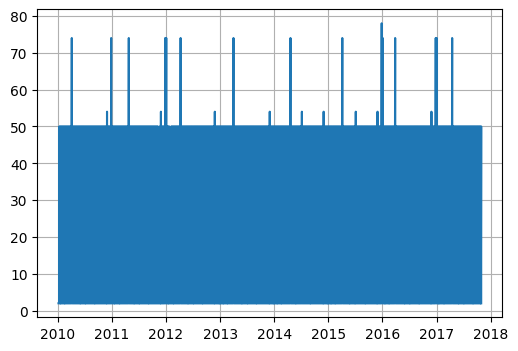

            ticker
hours_diff        
2.0          23638
4.0              2
6.0             45
18.0             2
26.0             3
30.0             3
32.0             2
50.0           382
54.0             9
74.0            14
78.0             1


In [161]:
# time series plot of 'hours_diff' shows smooth behavior with 
# jumps at 2 hour and after that 50 hour

final_data['datetime_diff'] = final_data['datetime_'].diff()
final_data['hours_diff'] = final_data['datetime_diff'].dt.total_seconds()/3600


%matplotlib inline
import matplotlib.pyplot as plt
#trade_data=big_data
plt.figure(figsize=(6,4))
plt.plot(final_data['datetime_'],final_data['hours_diff'])   # range(len(final_data))
plt.grid()
plt.show()

count = final_data[['hours_diff','ticker']].groupby(['hours_diff']).count() 
print(count) 


In [166]:
# 6 hour jumps seem to be related to times when the market is open half day

select_data = final_data[final_data['hours_diff']==6]

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
     select_data = final_data[final_data['hours_diff']==6]
     print(final_data[['ticker','datetime_','hours_diff','datetime_diff']].iloc[select_data['row_num'][0]-5:select_data['row_num'][0]+5])

                      ticker           datetime_  hours_diff   datetime_diff
datetime                                                                    
2010-01-18 04:00:00  CLH2010 2010-01-18 04:00:00         2.0 0 days 02:00:00
2010-01-18 06:00:00  CLH2010 2010-01-18 06:00:00         2.0 0 days 02:00:00
2010-01-18 08:00:00  CLH2010 2010-01-18 08:00:00         2.0 0 days 02:00:00
2010-01-18 10:00:00  CLH2010 2010-01-18 10:00:00         2.0 0 days 02:00:00
2010-01-18 12:00:00  CLH2010 2010-01-18 12:00:00         2.0 0 days 02:00:00
2010-01-18 18:00:00  CLH2010 2010-01-18 18:00:00         6.0 0 days 06:00:00
2010-01-18 20:00:00  CLH2010 2010-01-18 20:00:00         2.0 0 days 02:00:00
2010-01-18 22:00:00  CLH2010 2010-01-18 22:00:00         2.0 0 days 02:00:00
2010-01-19 00:00:00  CLH2010 2010-01-19 00:00:00         2.0 0 days 02:00:00
2010-01-19 02:00:00  CLH2010 2010-01-19 02:00:00         2.0 0 days 02:00:00


In [14]:
# prep.get_features data seems grab the features in the expected order
# and the field values seem accurate

import strategy_development.cnn.cnn2.prepare_data as prep
import pandas as pd
final_data = prep.prepare_2H_data()
feature_data = prep.get_features(df=final_data)
with pd.option_context('display.width', 150,'display.max_seq_items', None):
    print(feature_data.columns)
print(10*"*")
print(feature_data.columns[100:])

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    print(feature_data[['open','open_3','high','high_3','close','close_3','volume','volume_3']].iloc[50:70])

Index(['open', 'open_1', 'open_2', 'open_3', 'open_4', 'open_5', 'open_6', 'open_7', 'open_8', 'open_9', 'open_10', 'open_11', 'open_12', 'open_13',
       'open_14', 'open_15', 'open_16', 'open_17', 'open_18', 'open_19', 'open_20', 'open_21', 'open_22', 'open_23', 'high', 'high_1', 'high_2',
       'high_3', 'high_4', 'high_5', 'high_6', 'high_7', 'high_8', 'high_9', 'high_10', 'high_11', 'high_12', 'high_13', 'high_14', 'high_15',
       'high_16', 'high_17', 'high_18', 'high_19', 'high_20', 'high_21', 'high_22', 'high_23', 'low', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5',
       'low_6', 'low_7', 'low_8', 'low_9', 'low_10', 'low_11', 'low_12', 'low_13', 'low_14', 'low_15', 'low_16', 'low_17', 'low_18', 'low_19',
       'low_20', 'low_21', 'low_22', 'low_23', 'close', 'close_1', 'close_2', 'close_3', 'close_4', 'close_5', 'close_6', 'close_7', 'close_8',
       'close_9', 'close_10', 'close_11', 'close_12', 'close_13', 'close_14', 'close_15', 'close_16', 'close_17', 'close_18', 'cl

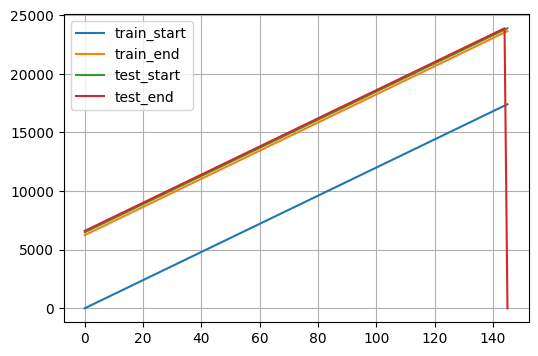

example case:
train_start_index: 6600
train_end_index: 12840
test_start_index: 13080
test_end_index: 13200
next train_start_index: 6720
next train_end_index: 12960
next test_start_index: 13200
next test_end_index: 13320


In [15]:
# indices provided by prep.prepare_rolling_simulation_indices seems accurate

import strategy_development.cnn.cnn2.prepare_data as prep
final_data = prep.prepare_2H_data()
rolling_indices_output = prep.prepare_rolling_simulation_indices(entire_data=final_data)

train_start_index_list = rolling_indices_output['train_start_index_list']
train_end_index_list = rolling_indices_output['train_end_index_list']

test_start_index_list = rolling_indices_output['test_start_index_list']
test_end_index_list = rolling_indices_output['test_end_index_list']

%matplotlib inline
import matplotlib.pyplot as plt
#trade_data=big_data
plt.figure(figsize=(6,4))
plt.plot(range(len(train_start_index_list)),train_start_index_list,
         range(len(train_end_index_list)),train_end_index_list,
         range(len(test_start_index_list)),test_start_index_list,
         range(len(test_end_index_list)),test_end_index_list)   # range(len(final_data))
plt.grid()
plt.legend(['train_start','train_end','test_start','test_end'])
plt.show()

i = 55
print('example case:')
print('train_start_index: ' + str(train_start_index_list[i]))
print('train_end_index: ' + str(train_end_index_list[i]))
print('test_start_index: ' + str(test_start_index_list[i]))
print('test_end_index: ' + str(test_end_index_list[i]))
print('next train_start_index: ' + str(train_start_index_list[i+1]))
print('next train_end_index: ' + str(train_end_index_list[i+1]))
print('next test_start_index: ' + str(test_start_index_list[i+1]))
print('next test_end_index: ' + str(test_end_index_list[i+1]))


In [203]:
# calculation of x_train_i, y_train_i, x_test_i, t_test_i seems accurate

import strategy_development.cnn.cnn2.prepare_data as prep
import numpy as np
final_data = prep.prepare_2H_data()
feature_data = prep.get_features(df=final_data)
rolling_indices_output = prep.prepare_rolling_simulation_indices(entire_data=final_data)

train_start_index_list = rolling_indices_output['train_start_index_list']
train_end_index_list = rolling_indices_output['train_end_index_list']

test_start_index_list = rolling_indices_output['test_start_index_list']
test_end_index_list = rolling_indices_output['test_end_index_list']

i = 50

train_start_index = train_start_index_list[i]
train_end_index = train_end_index_list[i]

test_start_index = test_start_index_list[i]
test_end_index = test_end_index_list[i]

x_train_i = feature_data.iloc[train_start_index:train_end_index, :]
y_train_i = np.array(final_data['label'].iloc[train_start_index:train_end_index])

x_test_i = feature_data.iloc[test_start_index:test_end_index, :]
y_test_i = final_data['label'].iloc[test_start_index:test_end_index]

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    print(x_train_i.head())
    print(y_train_i[:5])
    print(x_test_i.head())
    print(y_test_i[:5])





                       open  open_1  open_2  open_3  open_4  open_5  open_6  open_7  open_8  open_9  open_10  open_11  open_12  open_13  open_14  open_15  open_16  open_17  open_18  open_19  open_20  open_21  open_22  open_23    high  high_1  high_2  high_3  high_4  high_5  high_6  high_7  high_8  high_9  high_10  high_11  high_12  high_13  high_14  high_15  high_16  high_17  high_18  high_19  high_20  high_21  high_22  high_23     low   low_1   low_2   low_3  low_4  low_5  low_6  low_7  low_8  low_9  low_10  low_11  low_12  low_13  low_14  low_15  low_16  low_17  low_18  low_19  low_20  low_21  low_22  low_23   close  close_1  close_2  close_3  close_4  close_5  close_6  close_7  close_8  close_9  close_10  close_11  close_12  close_13  close_14  close_15  close_16  close_17  close_18  close_19  close_20  close_21  close_22  close_23  volume  volume_1  volume_2  volume_3  volume_4  volume_5  volume_6  volume_7  volume_8  volume_9  volume_10  volume_11  volume_12  volume_13  \
datetime

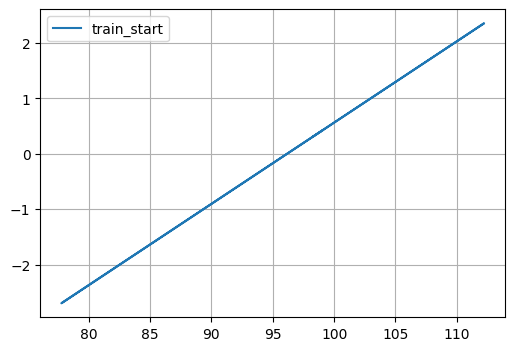

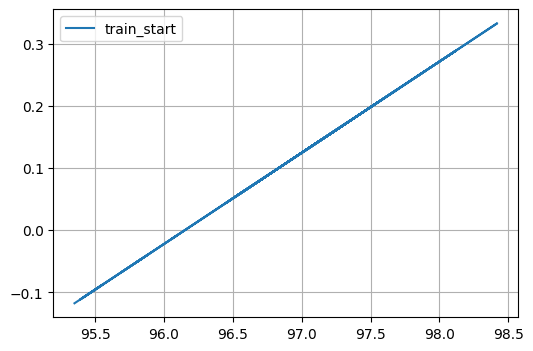

In [207]:
# fit_transform seems to have worked accurately

import strategy_development.cnn.cnn2.prepare_data as prep
import numpy as np
from sklearn.preprocessing import StandardScaler

final_data = prep.prepare_2H_data()
feature_data = prep.get_features(df=final_data)
rolling_indices_output = prep.prepare_rolling_simulation_indices(entire_data=final_data)

train_start_index_list = rolling_indices_output['train_start_index_list']
train_end_index_list = rolling_indices_output['train_end_index_list']

test_start_index_list = rolling_indices_output['test_start_index_list']
test_end_index_list = rolling_indices_output['test_end_index_list']

i = 50

train_start_index = train_start_index_list[i]
train_end_index = train_end_index_list[i]

test_start_index = test_start_index_list[i]
test_end_index = test_end_index_list[i]

x_train_i = feature_data.iloc[train_start_index:train_end_index, :]
y_train_i = np.array(final_data['label'].iloc[train_start_index:train_end_index])

x_test_i = feature_data.iloc[test_start_index:test_end_index, :]
y_test_i = final_data['label'].iloc[test_start_index:test_end_index]

scaler_i = StandardScaler()
x_train_i_t = scaler_i.fit_transform(x_train_i)
x_test_i_t = scaler_i.transform(x_test_i)


%matplotlib inline
import matplotlib.pyplot as plt
#trade_data=big_data
plt.figure(figsize=(6,4))
plt.plot(x_train_i.iloc[:,5],x_train_i_t[:,5])   # range(len(final_data))
plt.grid()
plt.legend(['train_start','train_end','test_start','test_end'])
plt.show()

%matplotlib inline
import matplotlib.pyplot as plt
#trade_data=big_data
plt.figure(figsize=(6,4))
plt.plot(x_test_i.iloc[:,5],x_test_i_t[:,5])   # range(len(final_data))
plt.grid()
plt.legend(['train_start','train_end','test_start','test_end'])
plt.show()



In [3]:
# prep.reshape_data is correctly transofrming data into (num_obs,5,24) shaped matrix

import strategy_development.cnn.cnn2.prepare_data as prep
import numpy as np
from sklearn.preprocessing import StandardScaler

final_data = prep.prepare_2H_data()
feature_data = prep.get_features(df=final_data)
rolling_indices_output = prep.prepare_rolling_simulation_indices(entire_data=final_data)

train_start_index_list = rolling_indices_output['train_start_index_list']
train_end_index_list = rolling_indices_output['train_end_index_list']

test_start_index_list = rolling_indices_output['test_start_index_list']
test_end_index_list = rolling_indices_output['test_end_index_list']

i = 50

train_start_index = train_start_index_list[i]
train_end_index = train_end_index_list[i]

test_start_index = test_start_index_list[i]
test_end_index = test_end_index_list[i]

x_train_i = feature_data.iloc[train_start_index:train_end_index, :]
y_train_i = np.array(final_data['label'].iloc[train_start_index:train_end_index])

x_test_i = feature_data.iloc[test_start_index:test_end_index, :]
y_test_i = final_data['label'].iloc[test_start_index:test_end_index]

scaler_i = StandardScaler()
x_train_i_t = scaler_i.fit_transform(x_train_i)
x_test_i_t = scaler_i.transform(x_test_i)

x_train_reshaped = prep.reshape_data(x_train_i_t)
x_test_reshaped = prep.reshape_data(x_test_i_t)

print(x_train_i_t[100])
print(10*'*')
print(x_train_reshaped[100])
print(10*'*')
print(x_train_reshaped.shape)

[ 0.54164355  0.54576666  0.55317435  0.55302673  0.55457378  0.55146373
  0.5515551   0.55165046  0.5410822   0.53526902  0.53519448  0.52810174
  0.52513977  0.528054    0.5265175   0.53108934  0.5265926   0.51182451
  0.52246332  0.53131227  0.53434919  0.53860122  0.53111628  0.55450015
  0.54367804  0.54083666  0.54935883  0.54935488  0.54937635  0.54880453
  0.54490652  0.54798847  0.54760325  0.53570058  0.5313986   0.53470869
  0.5247514   0.53070716  0.52463261  0.52891197  0.53170622  0.52336566
  0.52231821  0.5332009   0.53015203  0.54046549  0.5400716   0.54590246
  0.54534836  0.54226972  0.55091935  0.55522507  0.55392991  0.55721719
  0.54935501  0.55527743  0.54521433  0.54201518  0.53471297  0.53454618
  0.52720321  0.52992792  0.52411956  0.5243198   0.53322743  0.51371956
  0.51347903  0.52810123  0.52539767  0.53845698  0.53560283  0.53385381
  0.54744472  0.54015878  0.5471461   0.55310749  0.55160762  0.55316547
  0.54996613  0.55157885  0.54868403  0.53964506  0

In [1]:
# one_hot_enc = OneHotEncoder(sparse_output=False, categories=[[0,1,2]])
# y_train_i_transformed = one_hot_enc.fit_transform(y_train_i.reshape(-1, 1))
# OneHotEncoder is working as expected

import strategy_development.cnn.cnn2.prepare_data as prep
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder



final_data = prep.prepare_2H_data()
feature_data = prep.get_features(df=final_data)
rolling_indices_output = prep.prepare_rolling_simulation_indices(entire_data=final_data)

train_start_index_list = rolling_indices_output['train_start_index_list']
train_end_index_list = rolling_indices_output['train_end_index_list']

test_start_index_list = rolling_indices_output['test_start_index_list']
test_end_index_list = rolling_indices_output['test_end_index_list']

i = 50

train_start_index = train_start_index_list[i]
train_end_index = train_end_index_list[i]

test_start_index = test_start_index_list[i]
test_end_index = test_end_index_list[i]

x_train_i = feature_data.iloc[train_start_index:train_end_index, :]
y_train_i = np.array(final_data['label'].iloc[train_start_index:train_end_index])

x_test_i = feature_data.iloc[test_start_index:test_end_index, :]
y_test_i = final_data['label'].iloc[test_start_index:test_end_index]

one_hot_enc = OneHotEncoder(sparse_output=False, categories=[[0,1,2]])  # , categories='auto'
y_train_i_transformed = one_hot_enc.fit_transform(y_train_i.reshape(-1, 1))

print(y_train_i[30:40])
print(y_train_i_transformed[30:40])
print(x_train_i.shape)

[1 2 2 1 1 1 1 2 0 0]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]
(6240, 120)


In [1]:
# The model has 1.1M trainable paramters and each training window has 6240 observations

import strategy_development.cnn.cnn2.prepare_data as prep

final_data = prep.prepare_2H_data()
rolling_indices_output = prep.prepare_rolling_simulation_indices(entire_data=final_data)

train_start_index_list = rolling_indices_output['train_start_index_list']
train_end_index_list = rolling_indices_output['train_end_index_list']

import strategy_development.cnn.cnn2.run_cnn as rc
model = rc.create_model_cnn()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 24, 32)         160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 6, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 6, 64)          6208      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 2, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 2, 128)         16512     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 1, 128)         0